In [1]:
import tensorflow as tf
import os

In [2]:
print(tf.__version__)

2.0.0


In [3]:
print(tf.__path__)

['D:\\Users\\ddjsj\\Anaconda3\\lib\\site-packages\\tensorflow']


In [4]:
!dir

 驱动器 C 中的卷没有标签。
 卷的序列号是 887C-D3D4

 C:\Users\ddjsj 的目录

2019/10/20  11:38    <DIR>          .
2019/10/20  11:38    <DIR>          ..
2019/04/17  07:58    <DIR>          .android
2019/10/20  07:53    <DIR>          .conda
2019/10/20  08:17                42 .condarc
2018/09/06  17:36    <DIR>          .eclipse
2019/10/20  11:14    <DIR>          .ipynb_checkpoints
2019/10/20  08:01    <DIR>          .ipython
2019/10/20  09:57    <DIR>          .jupyter
2019/10/20  08:41    <DIR>          .keras
2019/10/20  08:33    <DIR>          .matplotlib
2019/03/28  19:27    <DIR>          .p2
2019/03/26  17:50            36,108 .pdfbox.cache
2019/08/25  09:48    <DIR>          .PyCharm2019.1
2018/09/06  17:01    <DIR>          .PyCharmCE2018.2
2018/09/06  17:36    <DIR>          .tooling
2019/10/20  07:58    <DIR>          Anaconda3
2018/07/23  10:12    <DIR>          AppData
2018/07/23  10:13    <DIR>          Contacts
2019/10/20  10:33    <DIR>          Desktop
2019/10/20  07:48    <DIR>         

In [5]:
tf.keras.backend.set_floatx('float64')

# Jupyter notebook

两种模式：
* 命令模式
   - r (raw) 原始文本
   - y (code) 代码 
   - m (mark down ) 格式化文本
   - a (above) 在当前cell的上方创建并插入一个cell
   - b (below) 下方
   - 1~6 不同级别的标题
* 编辑模式
    - Ctrl + /
    - Ctrl + Enter
    - Shift Enter|

In [6]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# mnist数据集

In [7]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import datasets, optimizers, layers

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

### 读入mnist数据集

In [9]:
mnist = datasets.mnist

In [10]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [11]:
type(train_images)

numpy.ndarray

In [12]:
type(train_labels)

numpy.ndarray

In [13]:
N_TRAINL, IMG_HEIGHT, IMG_WIDTH = train_images.shape

3


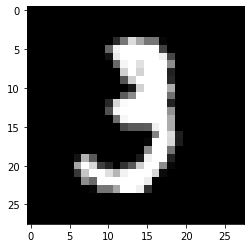

In [14]:
PIC = 10
plt.imshow(train_images[PIC], cmap = 'gray')
print(train_labels[PIC])

In [15]:
test_images.shape
# 784 = 28*28

(10000, 28, 28)

In [16]:
train_images = train_images/255.
test_images = test_images/255.
train_labels = tf.cast(train_labels, tf.float64)
test_labels = tf.cast(test_labels, tf.float64)

In [17]:
train_labels.shape

TensorShape([60000])

In [18]:
N_DATA = 20000
N_BATCH = 16
# 按batch，构建训练数据集\
def mnist_dataset(x, y):
    ds = tf.data.Dataset.from_tensor_slices((x,y)).take(N_DATA).shuffle(N_DATA).batch(N_BATCH)
    return ds

In [19]:
ds = mnist_dataset(train_images, train_labels)

### 构建神经网络

In [20]:
# 输入图片 --》 layer （加法操作+非线性操作）-》 layer （加法操作+非线性操作） ——》  。。。——> logits[0.7, 0.01, 0.08,....], SIGMA=1

In [21]:
# 构建神经元网络的拓扑结构

NEURONS_L1 = 128
NEURONS_L2 = 32
NEURONS_L3 = 10

# relu(x) = max(0, x)

model = keras.Sequential([
    layers.Reshape(target_shape = (IMG_HEIGHT * IMG_WIDTH, ), input_shape = (28,28)),
    layers.Dense(NEURONS_L1, activation = 'relu'),
    layers.Dense(NEURONS_L2, activation = 'relu'),
    layers.Dense(NEURONS_L3, activation = 'softmax')
])

### 选择损失函数loss

In [22]:
# 归一化的损失函数|
@tf.function
def compute_loss(logits, labels):
#     assert logits.shape == (N_BATCH, NEURONS_L3)
#     assert labels.shape == (N_BATCH,)
    return tf.reduce_mean(tf.losses.sparse_categorical_crossentropy(labels, logits))

### 计算评估用的精度acc

In [23]:
# 评估模型的好坏（在训练集、验证集和测试集上的表现）
# 精度（人类定义）


# logits.shape == (N_BATCH, NEURONS_L3)
# labels.shape == (N_BATCH, )
@tf.function
def compute_accuracy(logits, labels):
#     assert logits.shape == (N_BATCH, NEURONS_L3)
#     assert labels.shape == (N_BATCH,)
    predictions = tf.argmax(logits, axis = 1)   # prediciton.shape == (N_BATCH, )
#     assert predictions.shape == labels.shape
    return tf.reduce_mean(tf.cast(tf.equal(predictions, tf.cast(labels, tf.int64)), tf.float64))

### 选择最优化方法

In [24]:
# 数值最优化方法
# 梯度下降、牛顿法

# 调整权值weights
optimizer = optimizers.Adam(learning_rate = 0.001)

### 训练和评估

In [25]:
# 1.0 session

# 一个step/batch
@tf.function
def train_one_step(model, optimizer, x, y):
    # 获得梯度
    with tf.GradientTape( ) as tape:
        logits = model(x)
        loss = compute_loss(logits, y)
        
    # 计算梯度  
    grads = tape.gradient(loss, model.trainable_variables)
    
    # 更新参数 w <- w - grads * learning_rate
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    accuracy = compute_accuracy(logits, y)
    
    return loss, accuracy

# 一个epoch （整个训练集遍历了一遍）
@tf.function
def train(epoch, model, optimizer, train_images, train_labels):
    
    # 获取批数据
    train_ds = mnist_dataset(train_images, train_labels)

    loss = 0.
    loss = tf.cast(loss, tf.float64)
    accuracy = 0.
    accuracy = tf.cast(accuracy, tf.float64)
    
    for step, (x, y) in enumerate(train_ds):
        loss, accuracy = train_one_step(model, optimizer, x, y)
        
        if step % 100 == 0:
            print(f'epoch{epoch} step{step}, loss{loss}, accuracy{accuracy}')
            
    return loss, accuracy

# 遍历多次
N_EPOCHES = 1
for epoch in range(N_EPOCHES):
    loss, accuracy = train(epoch, model, optimizer, train_images, train_labels)
    print(f"Final epoch {epoch}, loss {loss}, accuracy {accuracy}") # f = format

epoch0 stepTensor("args_2:0", shape=(), dtype=int64), lossTensor("StatefulPartitionedCall:0", shape=(), dtype=float64), accuracyTensor("StatefulPartitionedCall:1", shape=(), dtype=float64)
Final epoch 0, loss 0.032269189818014785, accuracy 1.0
